# Import necessary packages and load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("data.csv")
df = data.copy()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


# Exploratory Data Analysis

In [3]:
def explore_dataset(df):
    "Gives basic information about dataset"
    print("\n Shape of dataset: ", df.shape)
    print("\n Columns of dataset: ", df.columns)
    print("\n", df.info())
    print("\n Null values in each column: ", df.isna().sum())
    print("\n Duplicate records in dataset: ", df.duplicated().sum())
    print("\n Basic statistical summary: \n", df.describe().T)



explore_dataset(df)


 Shape of dataset:  (4600, 18)

 Columns of dataset:  Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 

Here we got 4600 records and 18 columns. Our target variable is price.
There are total 13 numerical features (including target) and 5 categorical features.
There are no null values in any column and no duplicate records.

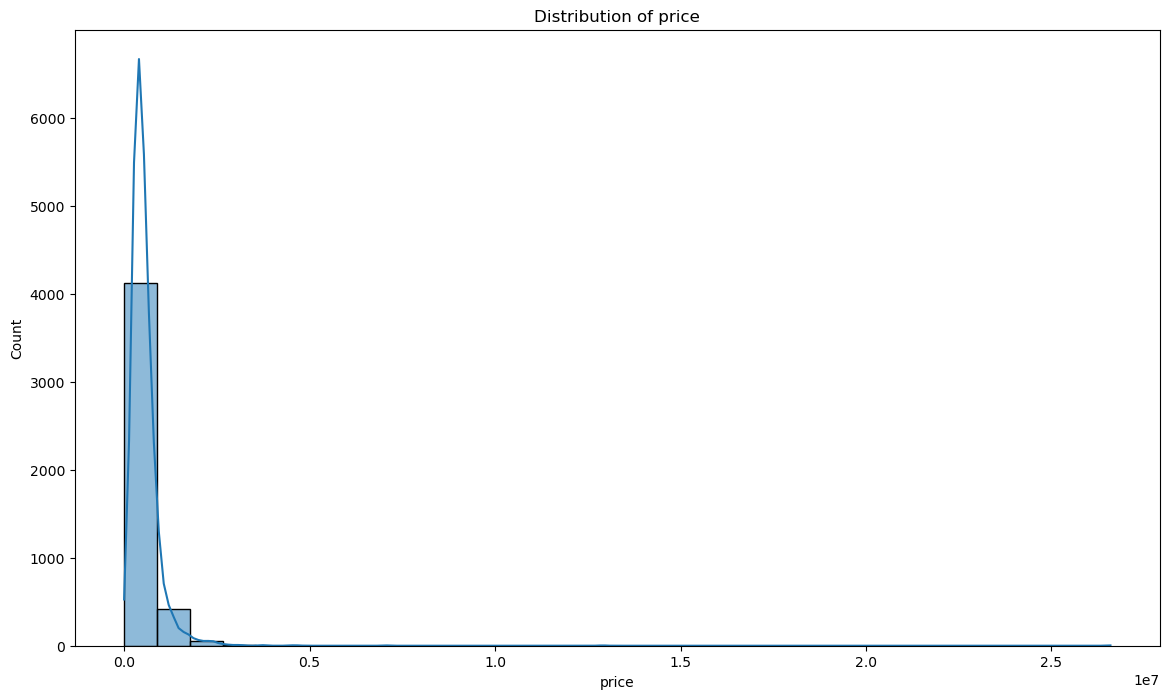

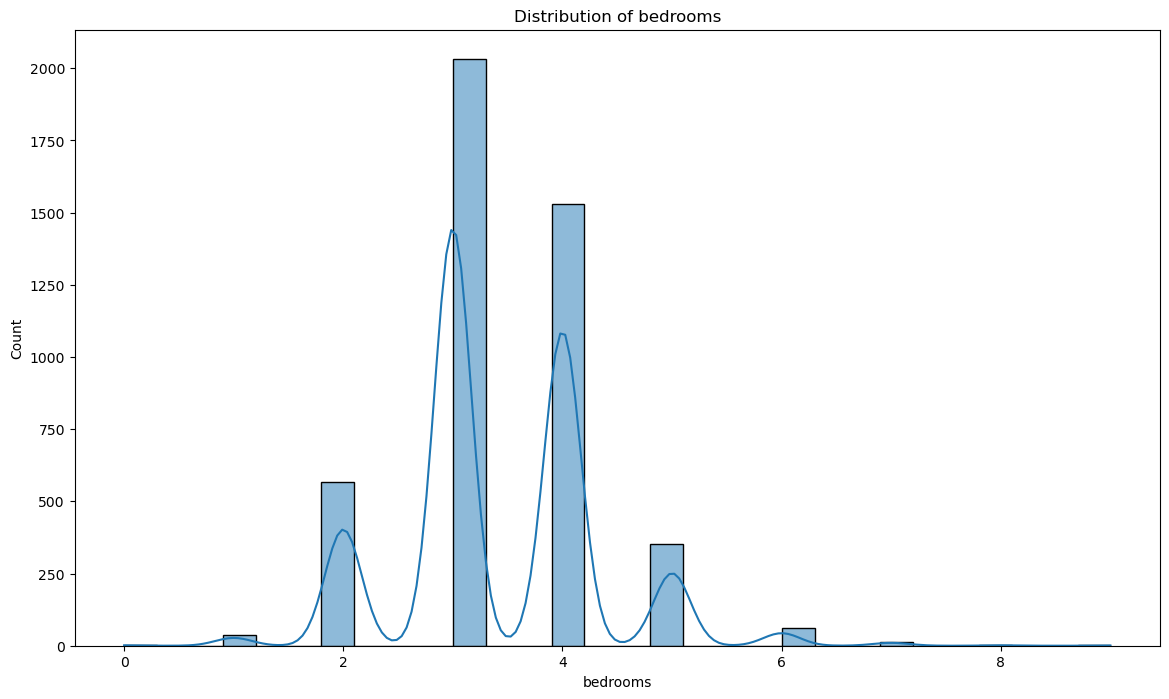

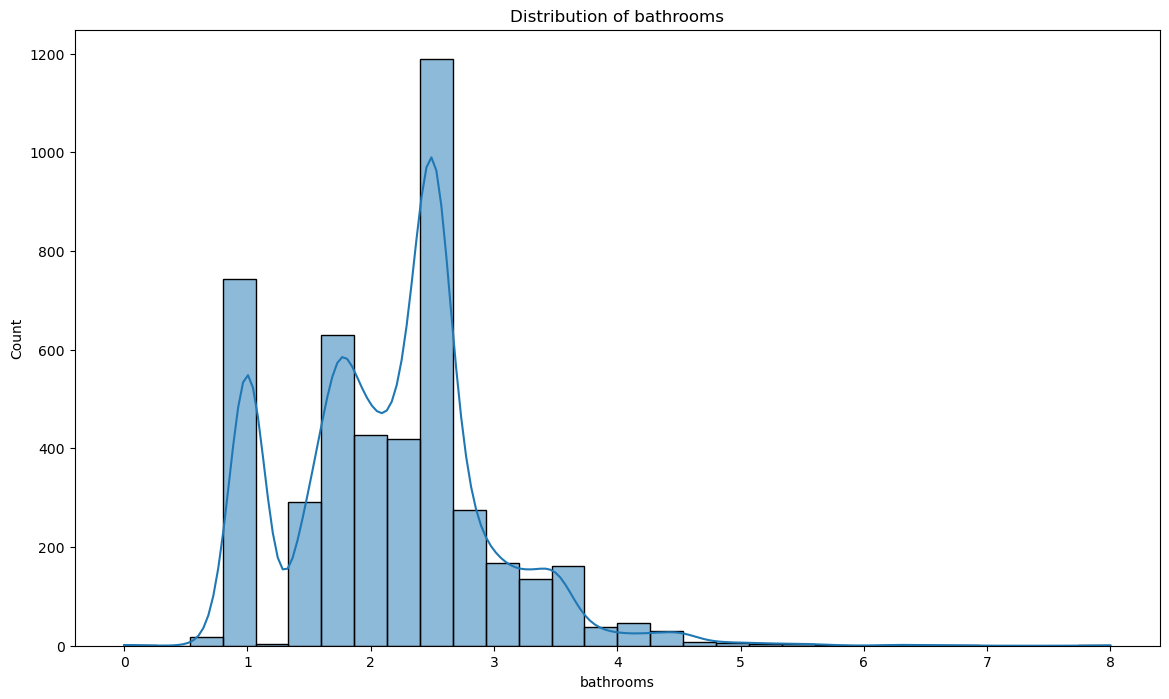

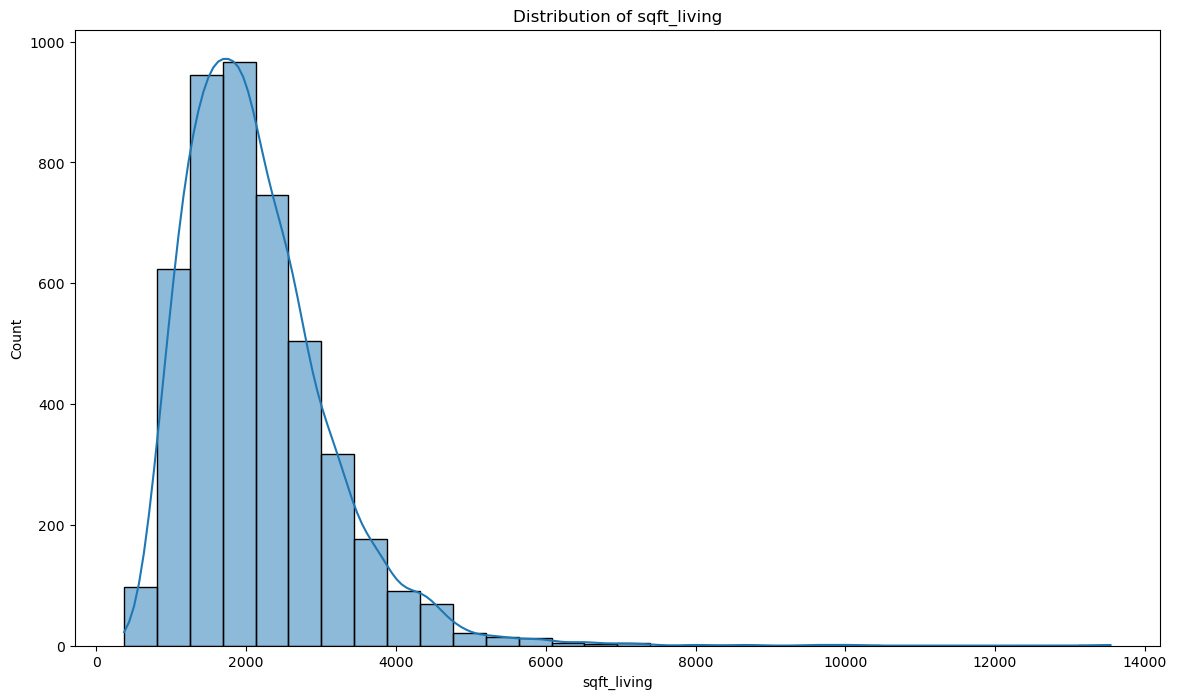

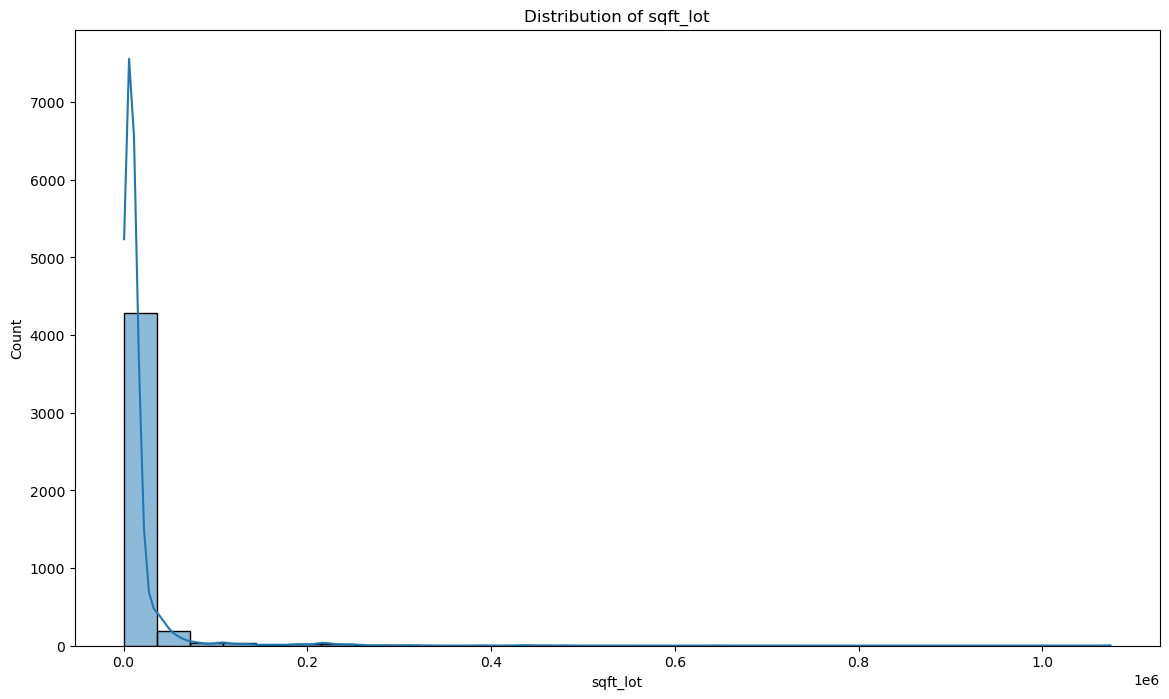

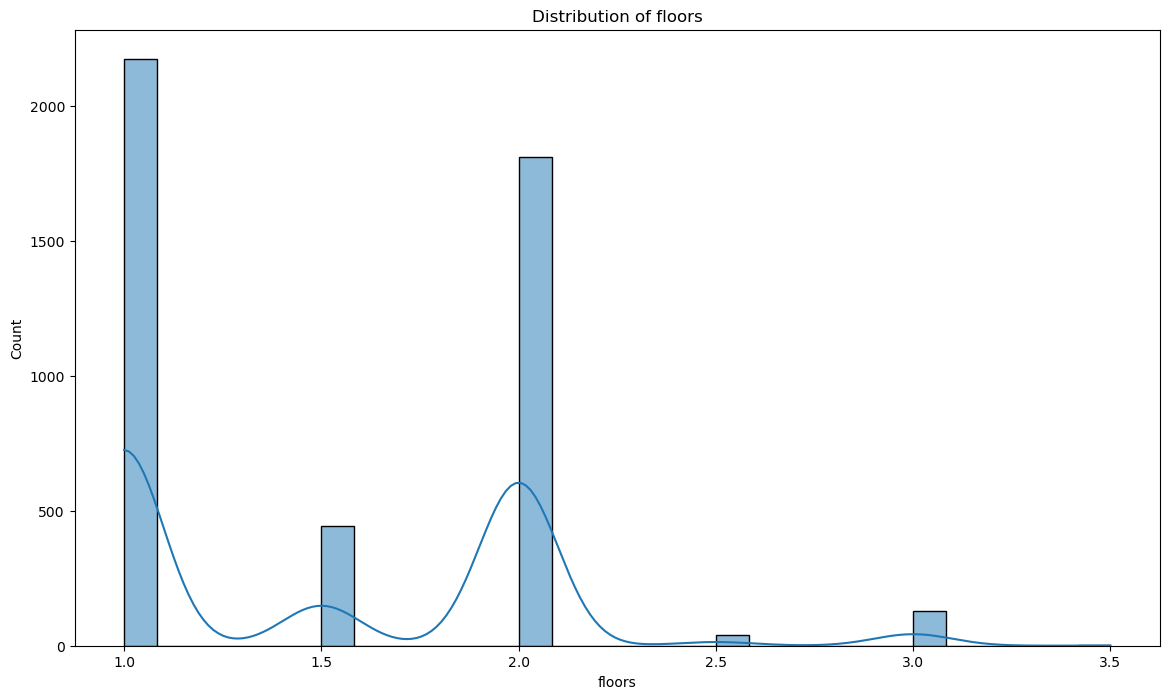

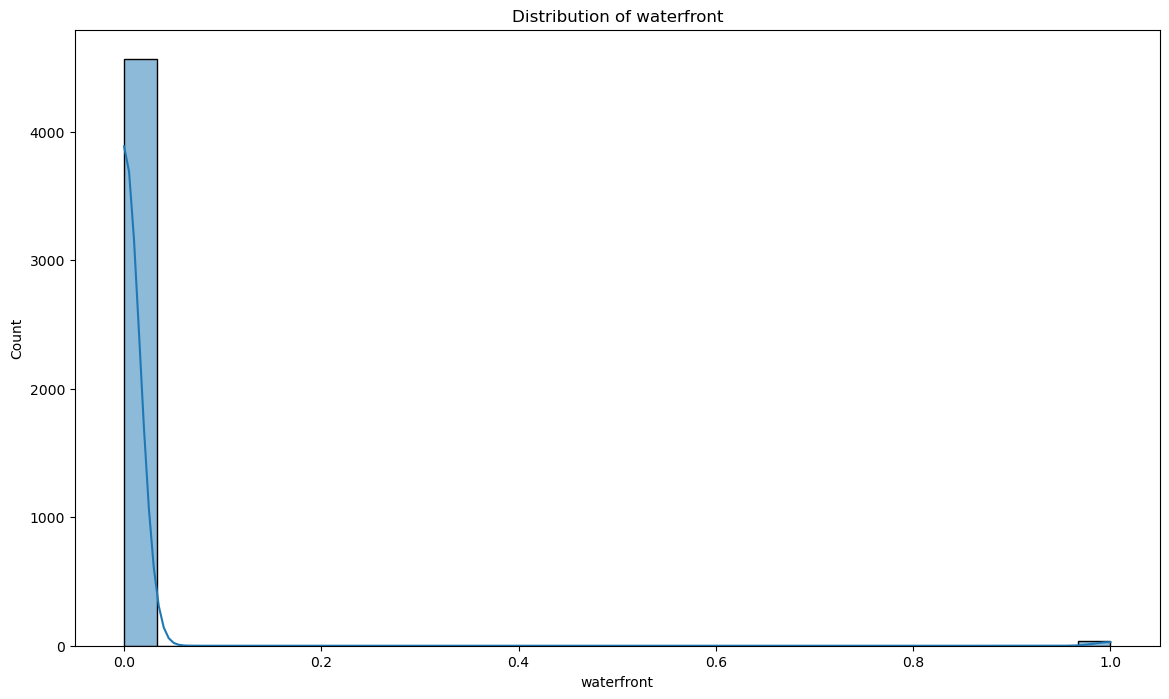

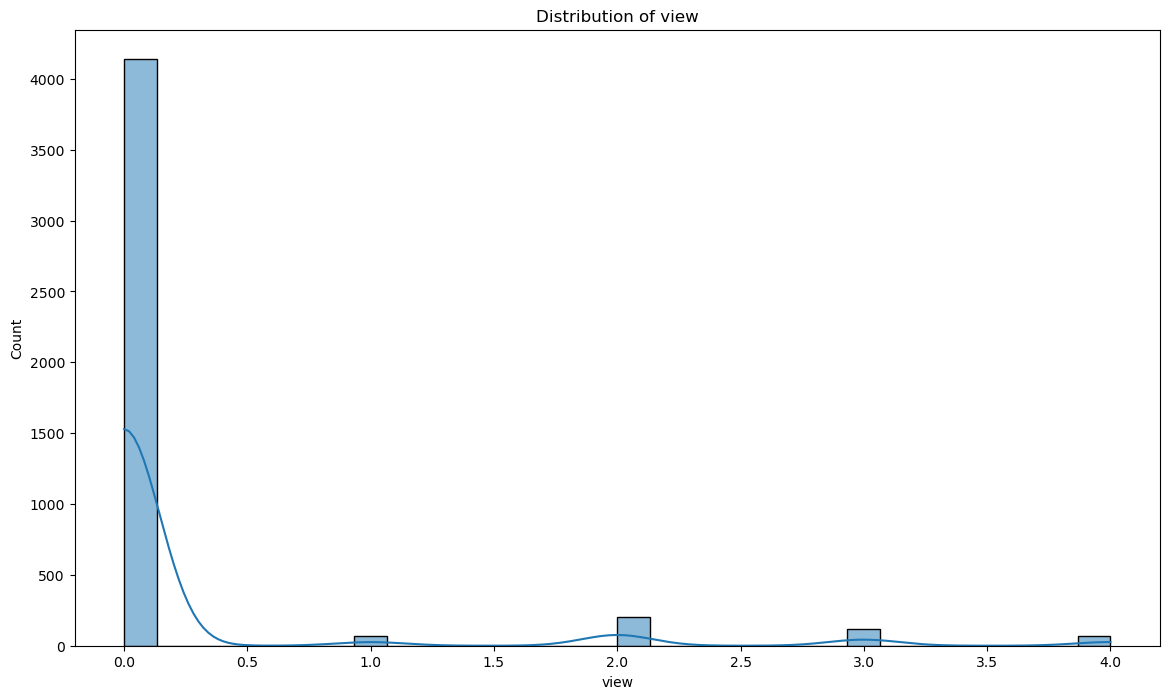

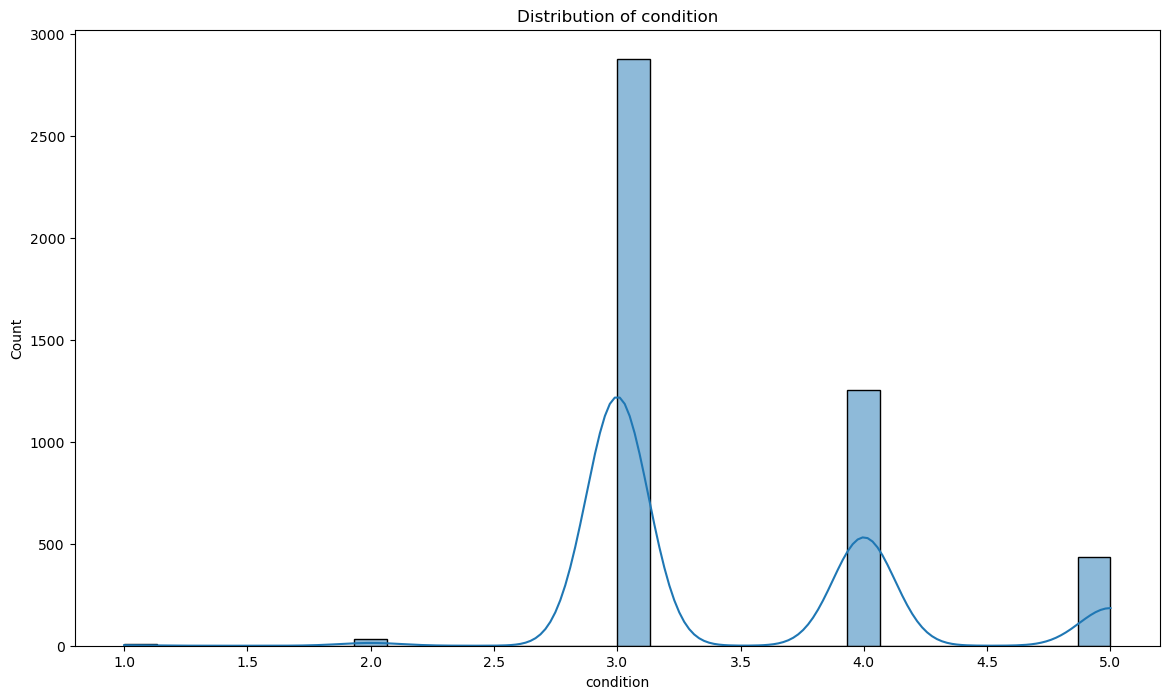

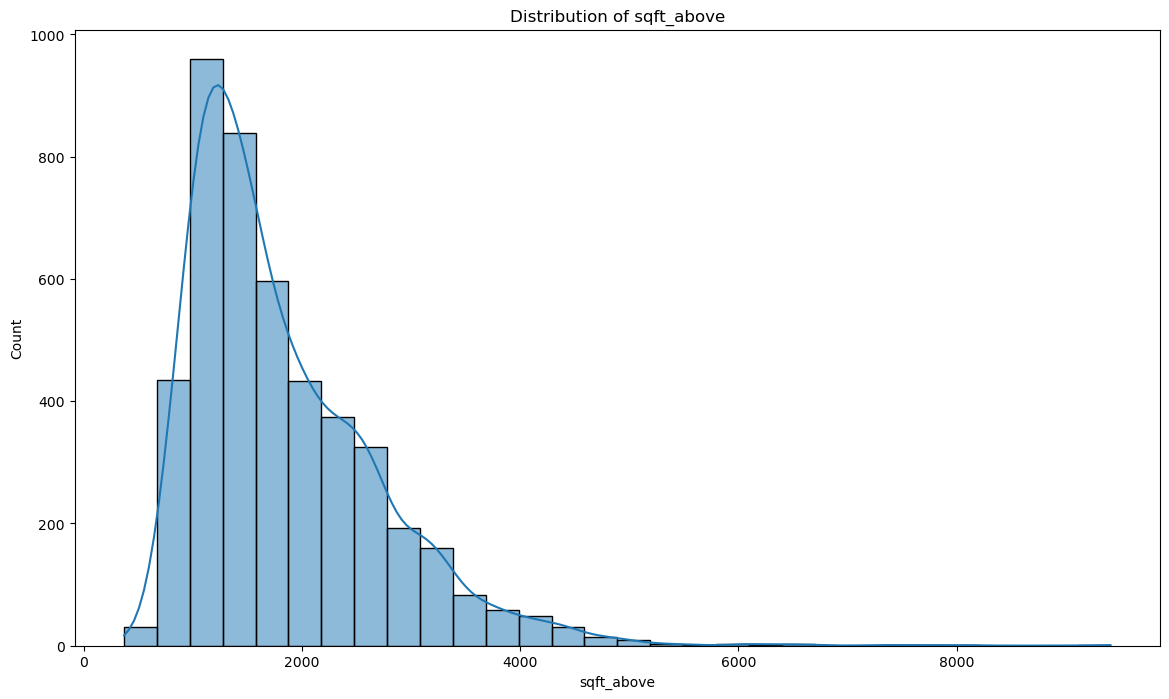

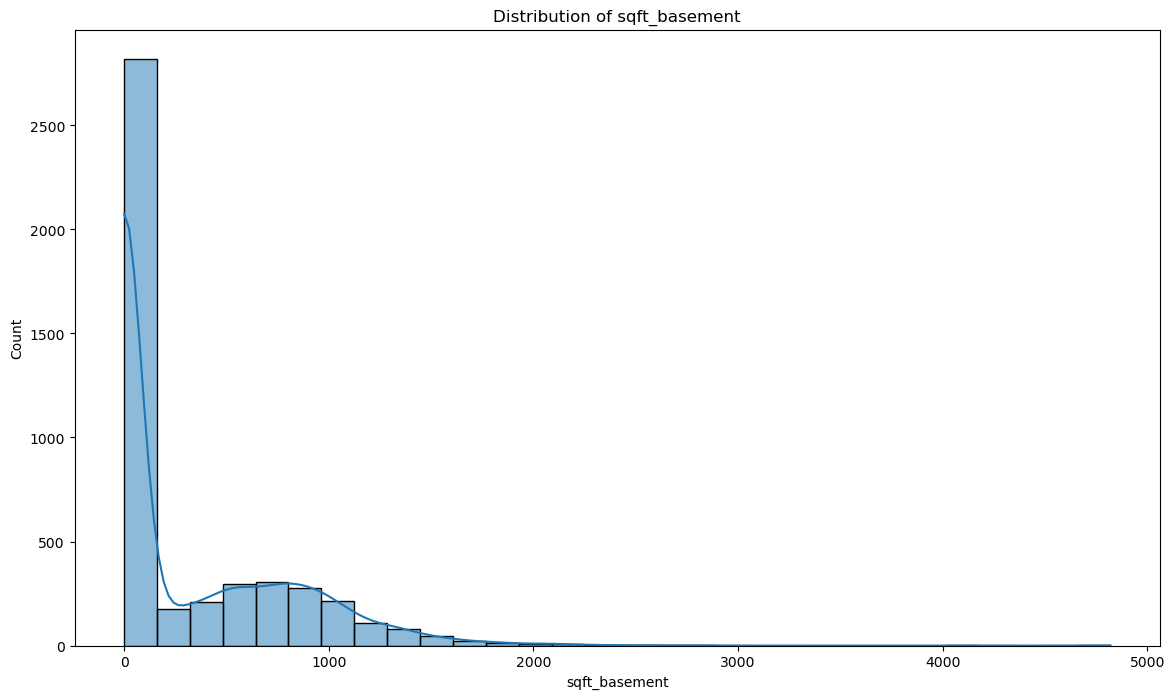

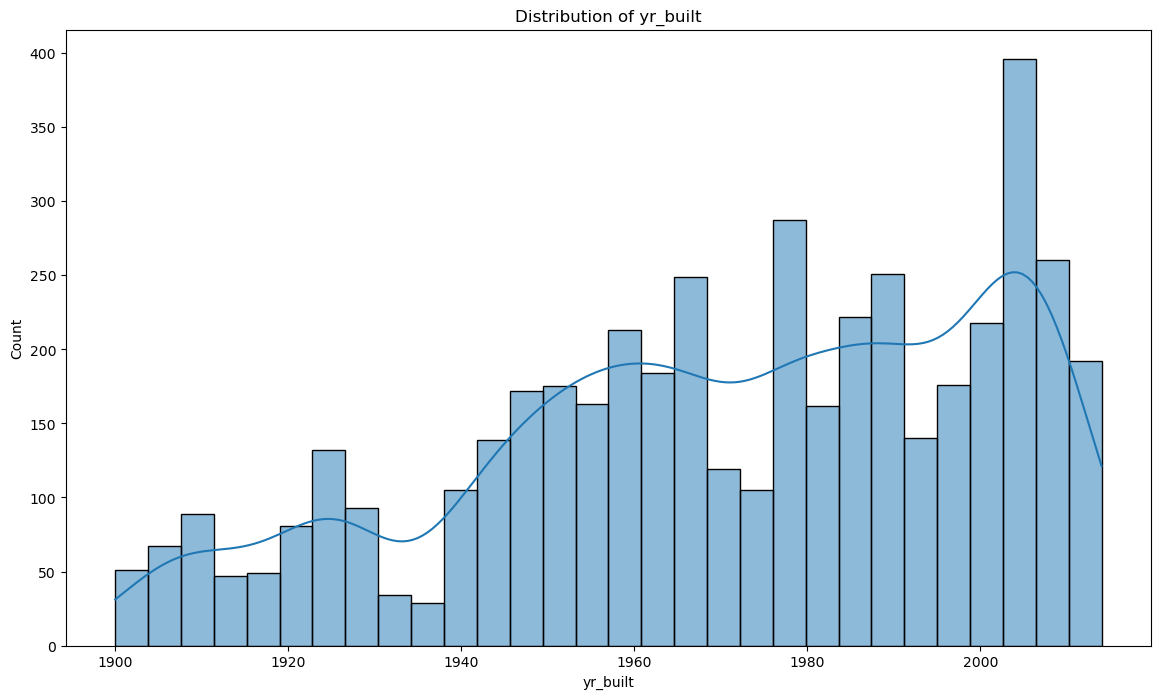

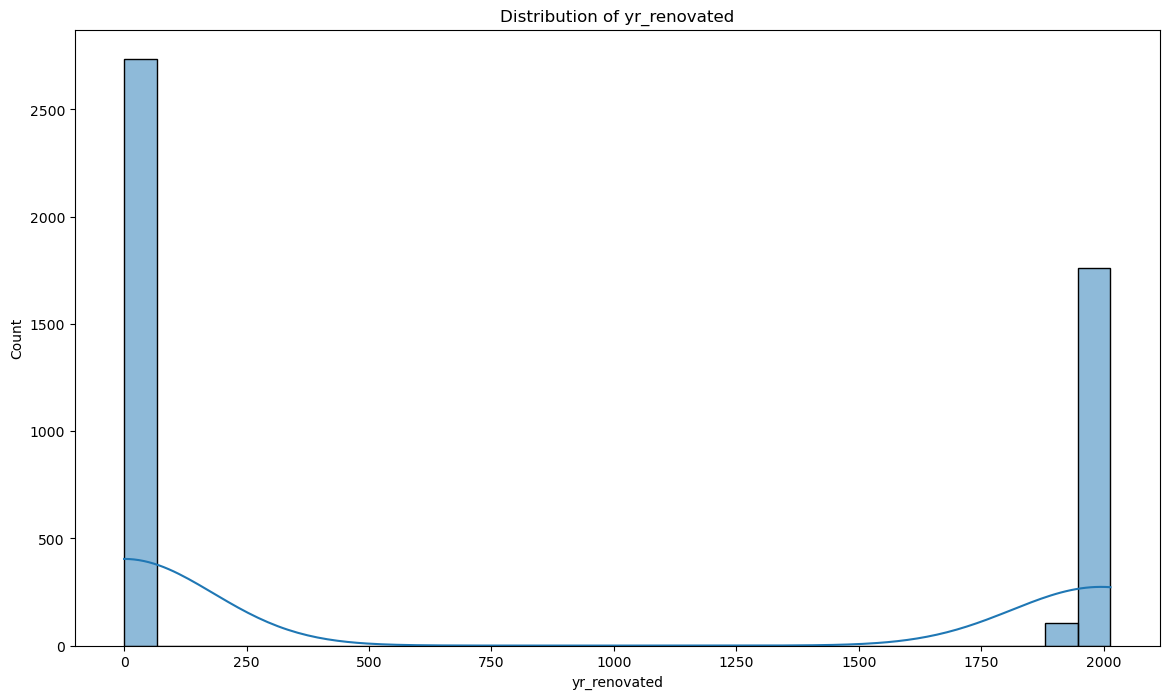

In [4]:
# Visualizing numerical columns
numerical_cols = df.select_dtypes(include=['int64','float64']).columns

# histogram
for col in numerical_cols:
    plt.figure(figsize=(14,8))
    sns.histplot(df[col], kde = True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

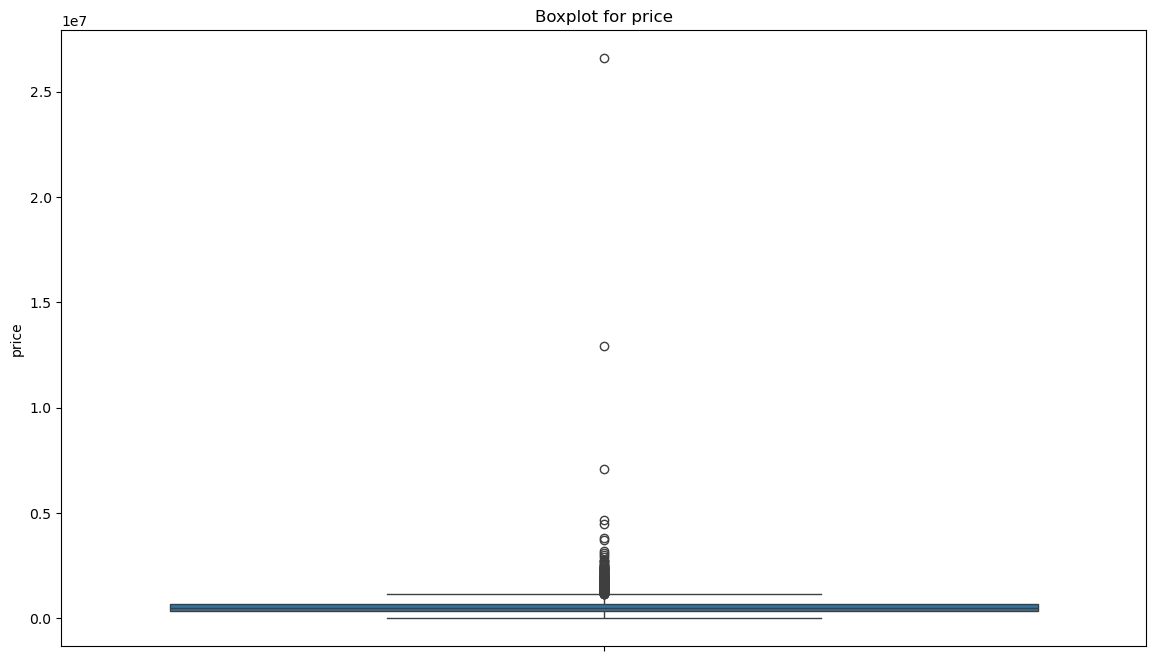

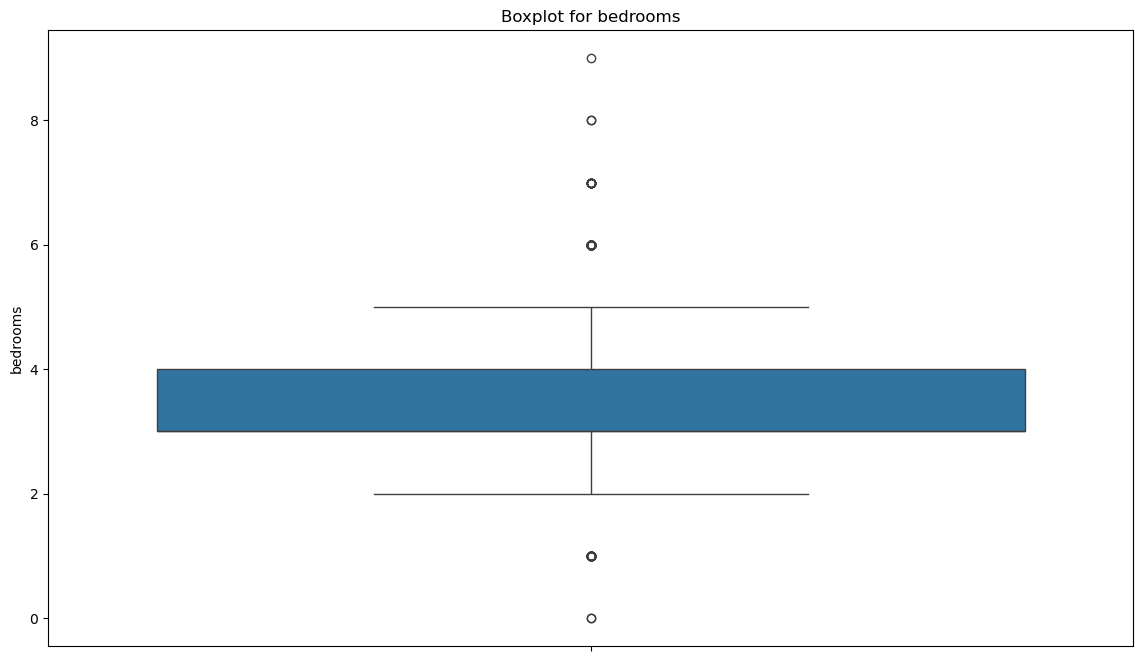

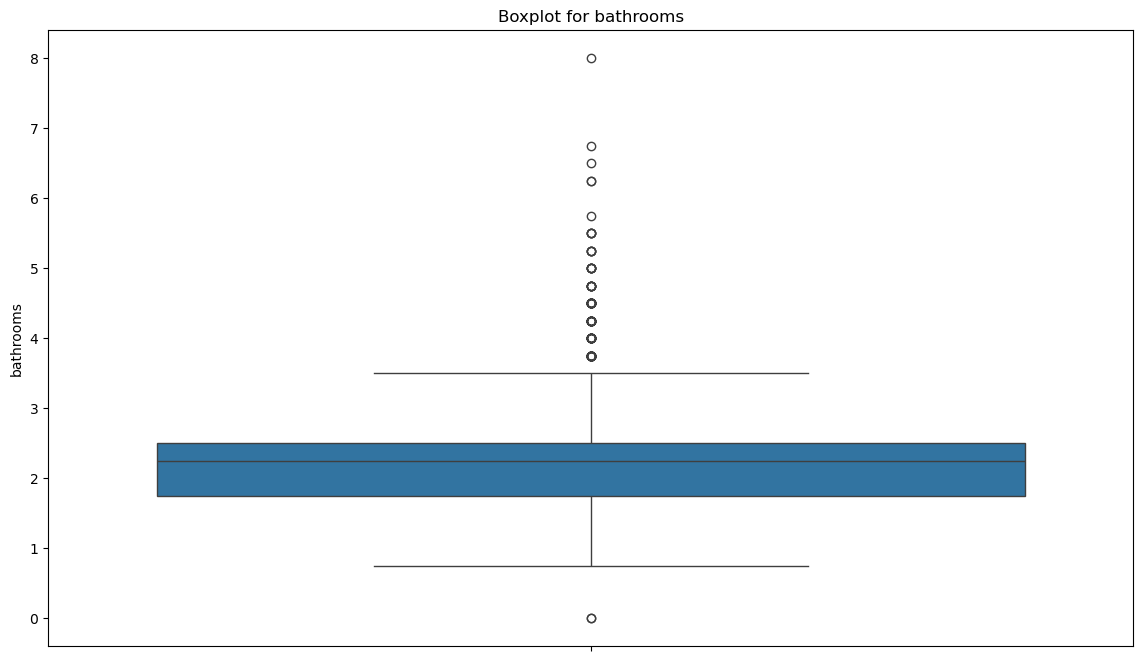

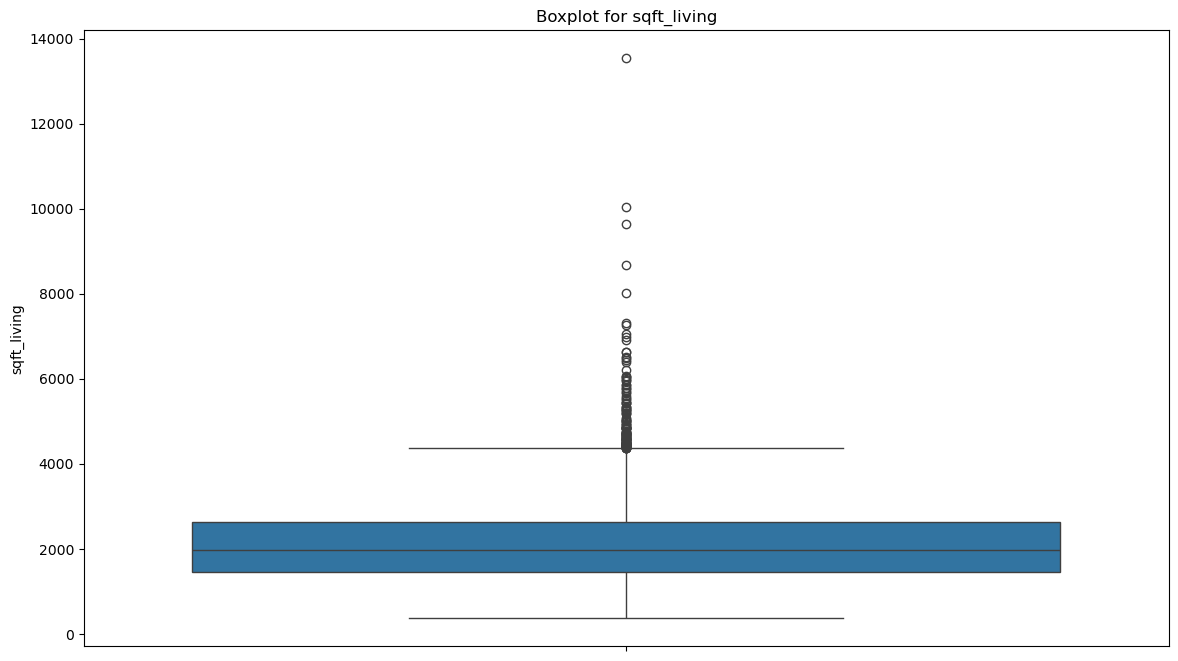

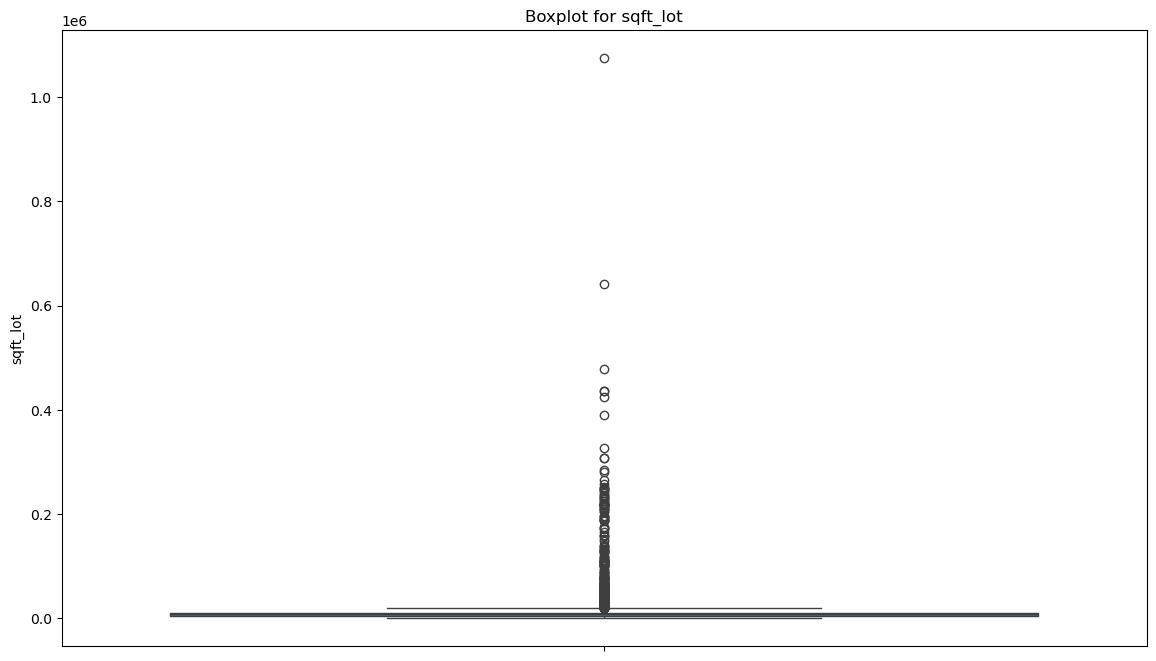

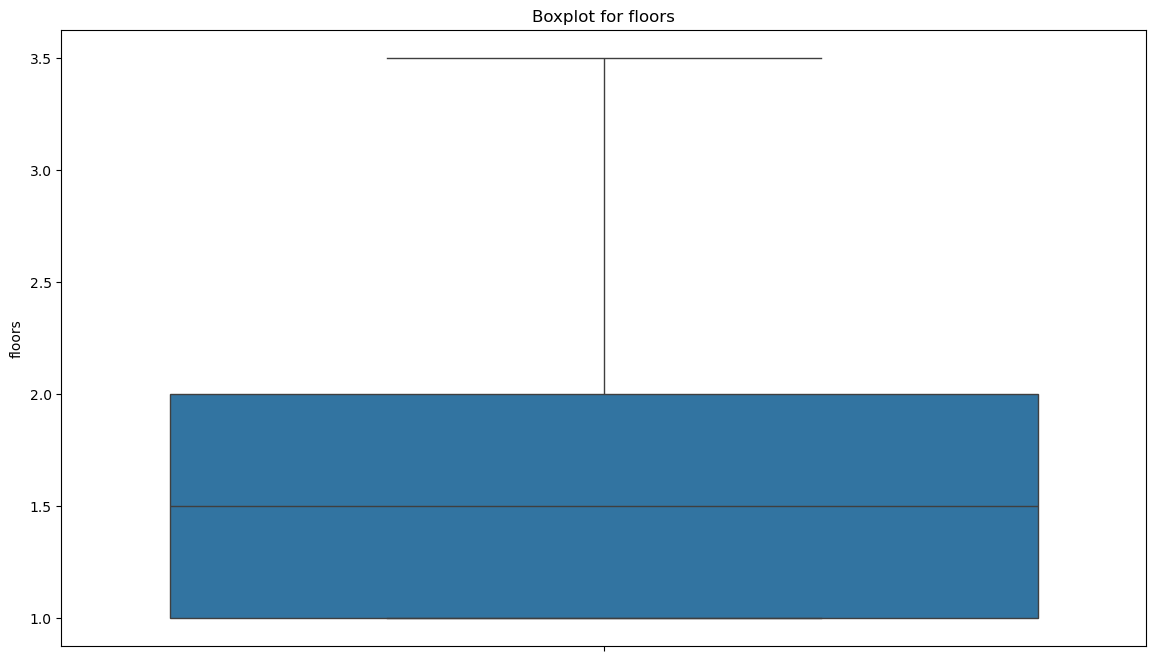

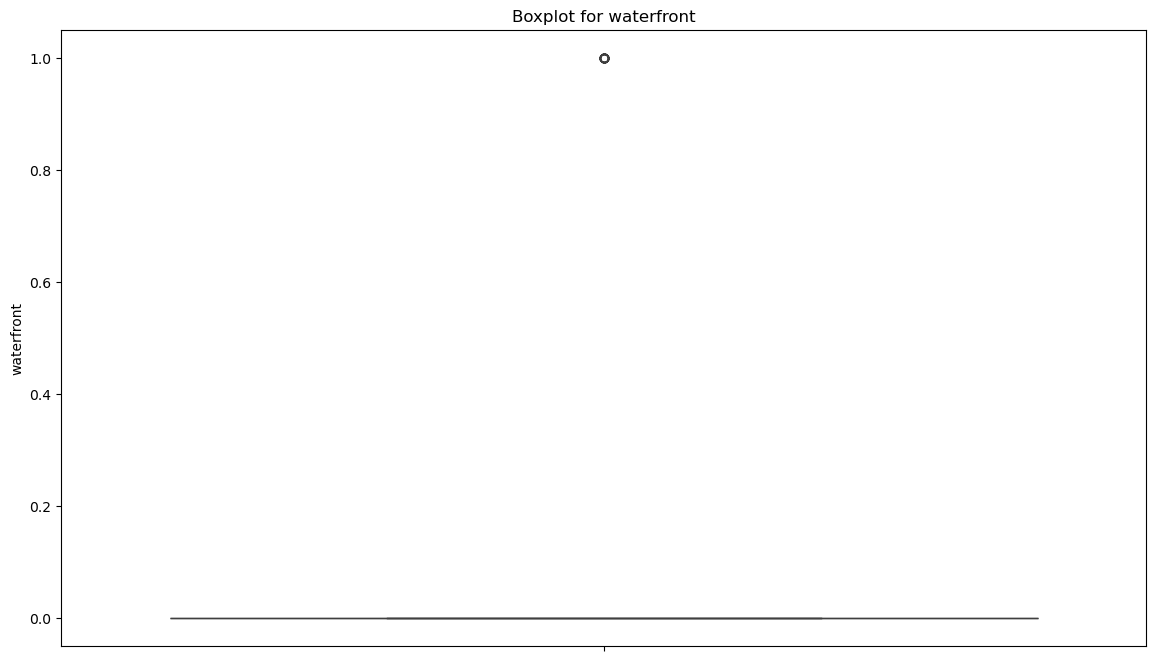

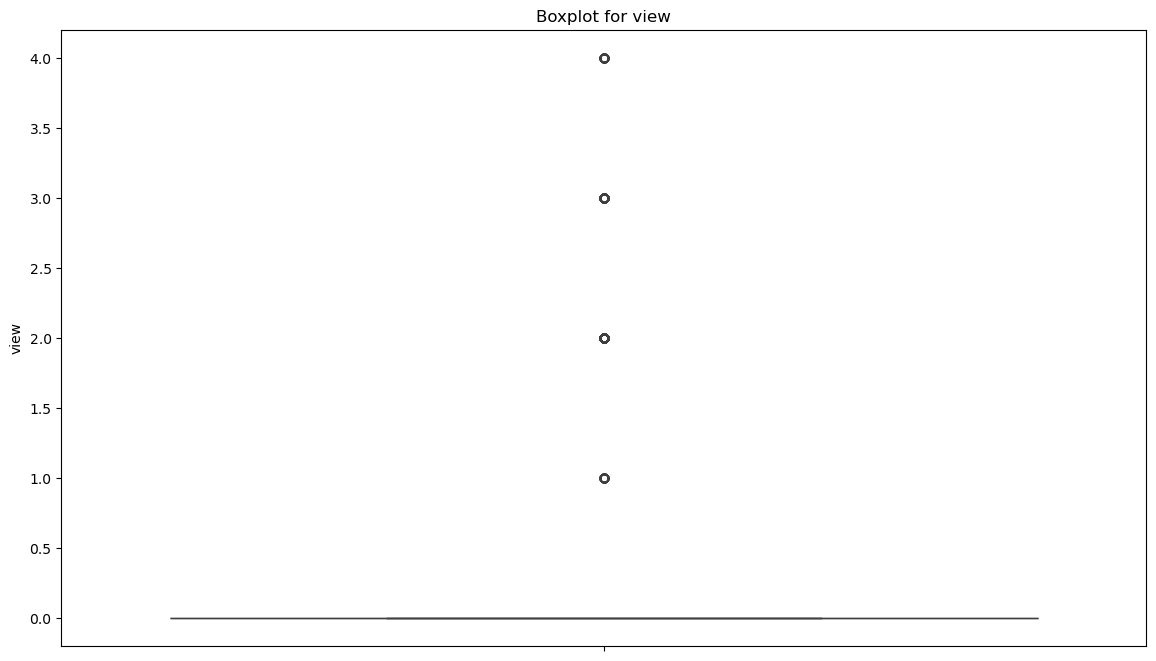

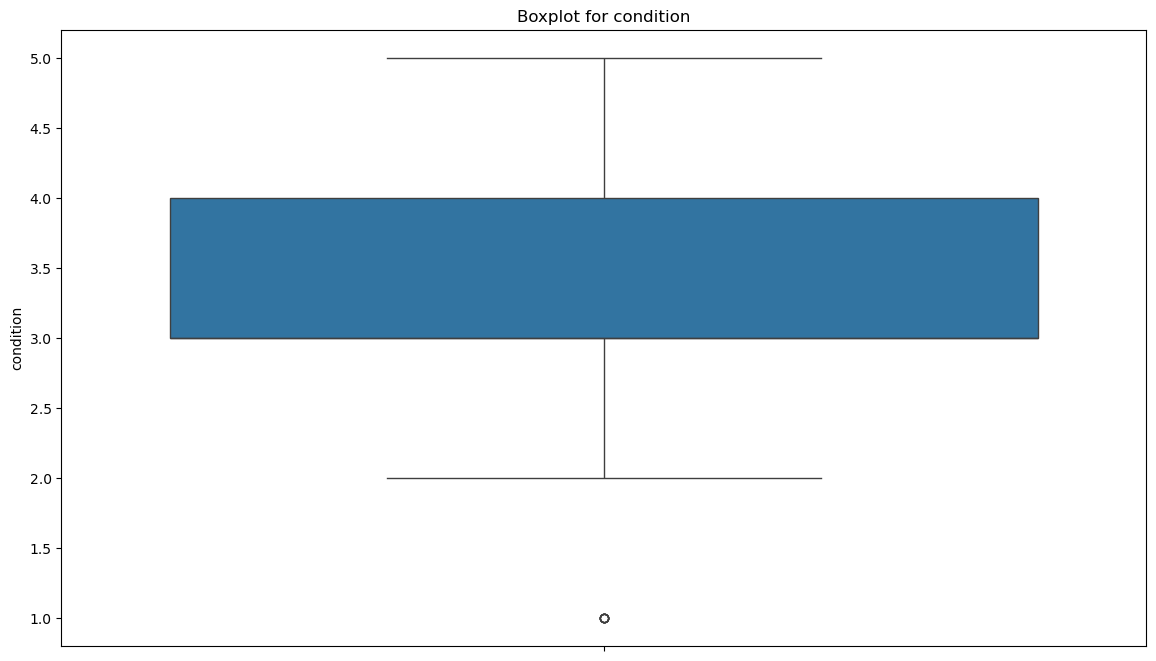

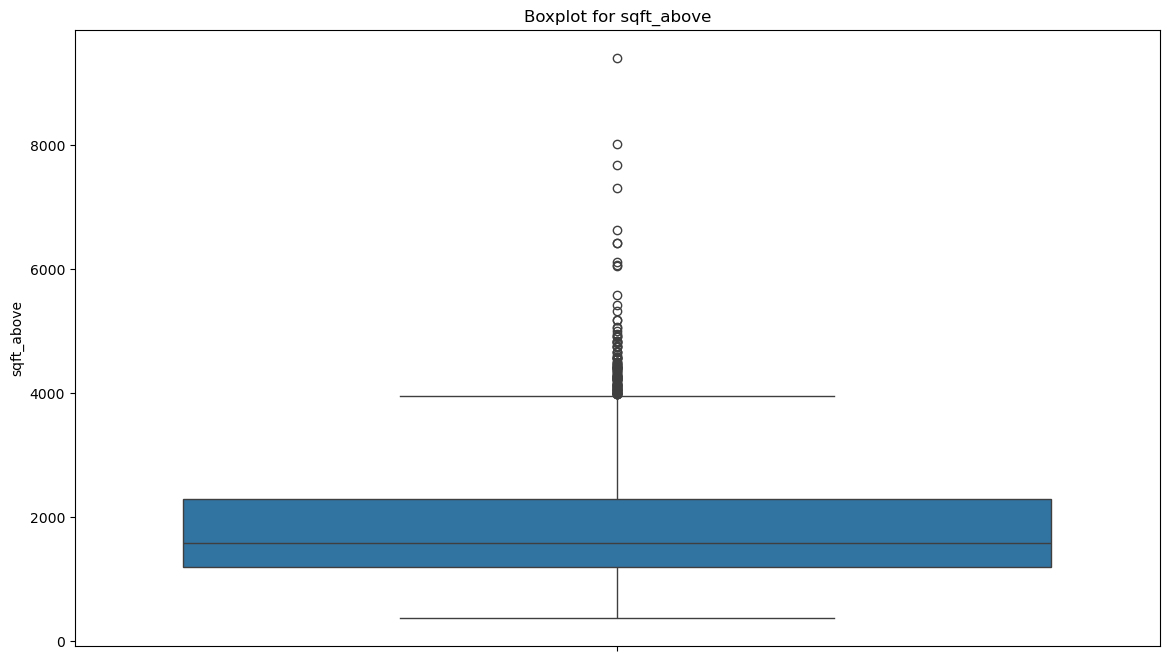

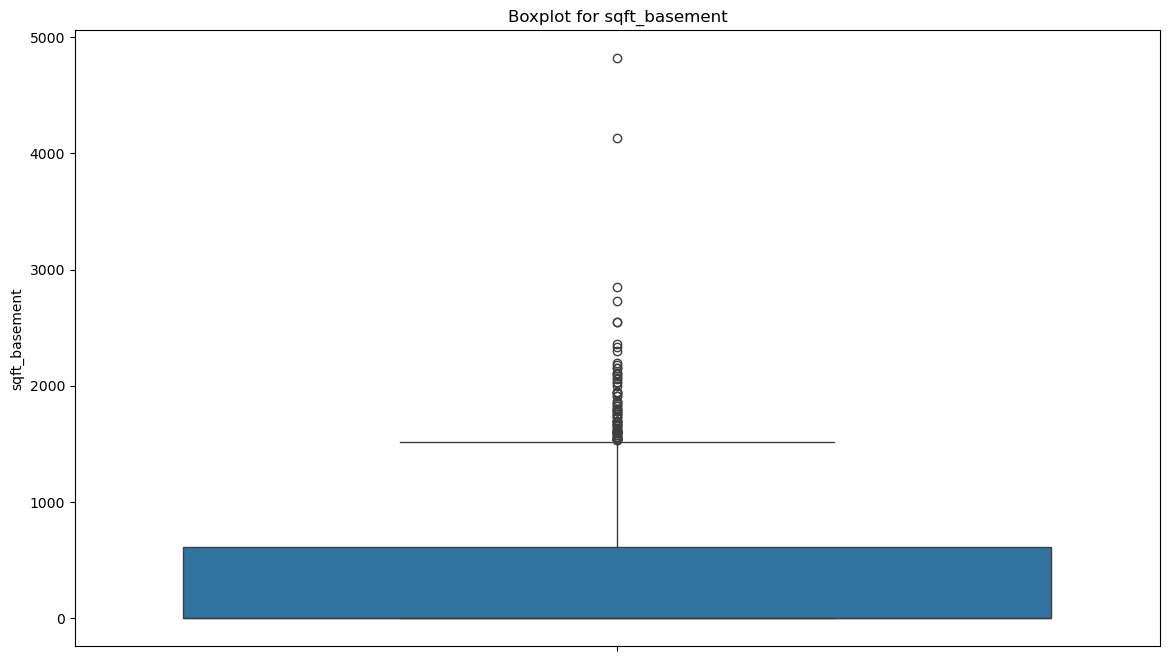

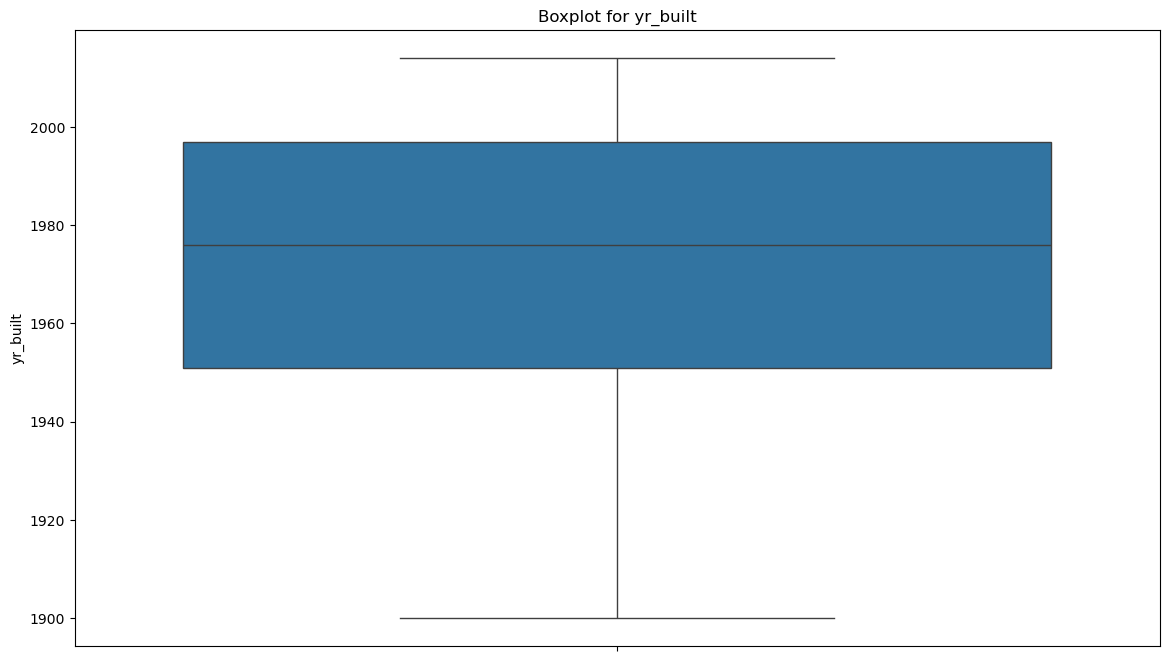

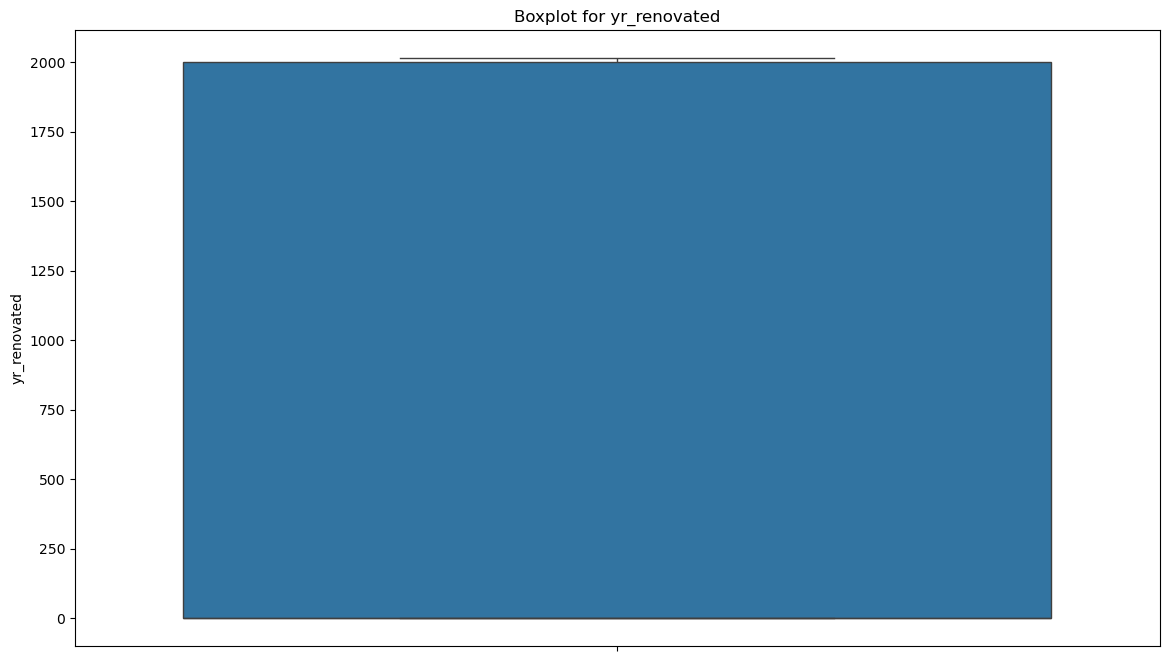

In [5]:
# Box plot for outlier detection
for col in numerical_cols:
    plt.figure(figsize=(14,8))
    sns.boxplot(df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [6]:
# Removing outliers
def remove_outliers(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_without_outlier = remove_outliers(df)
df_without_outlier.shape

(3316, 18)

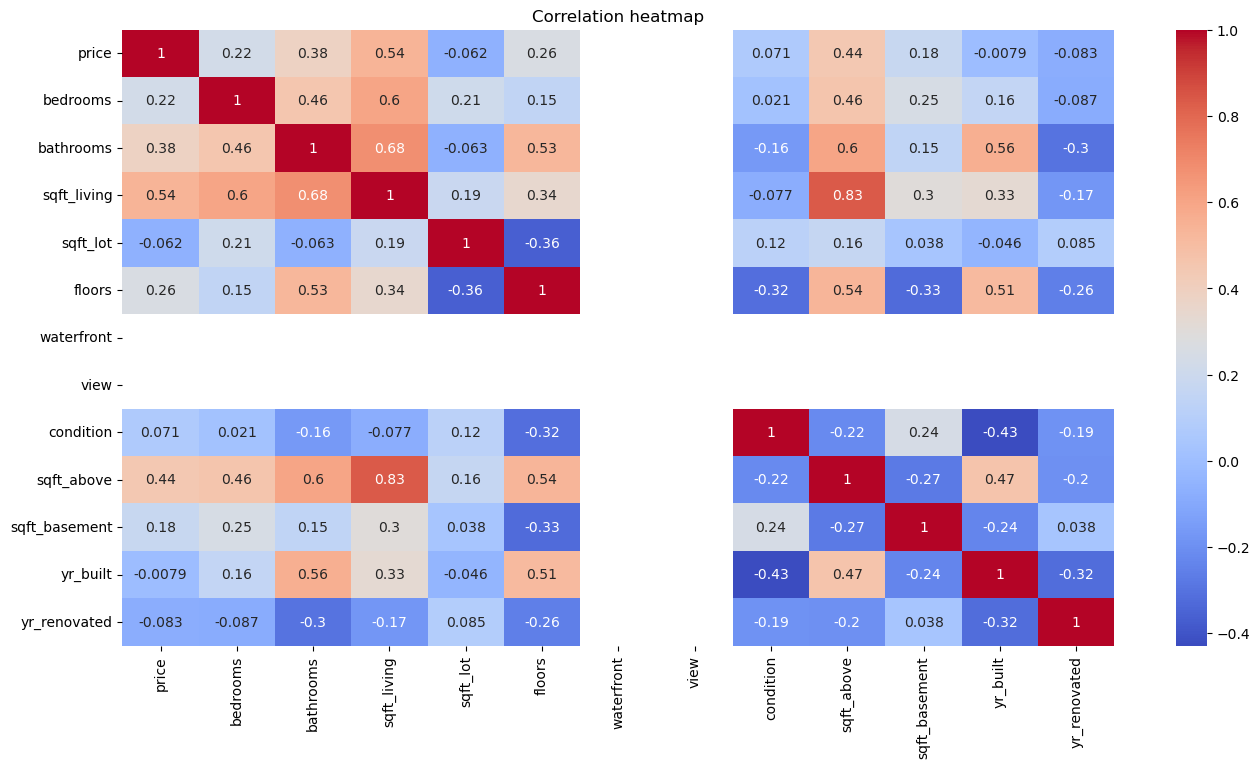

In [7]:
# correlation heatmap

def plot_corr_heatmap(df):
    num_cols = df_without_outlier.select_dtypes(include=['int64','float64']).columns
    plt.figure(figsize=(16,8))
    sns.heatmap(df_without_outlier[num_cols].corr(), annot = True, cmap = 'coolwarm')
    plt.title("Correlation heatmap")
    plt.show()


plot_corr_heatmap(df)


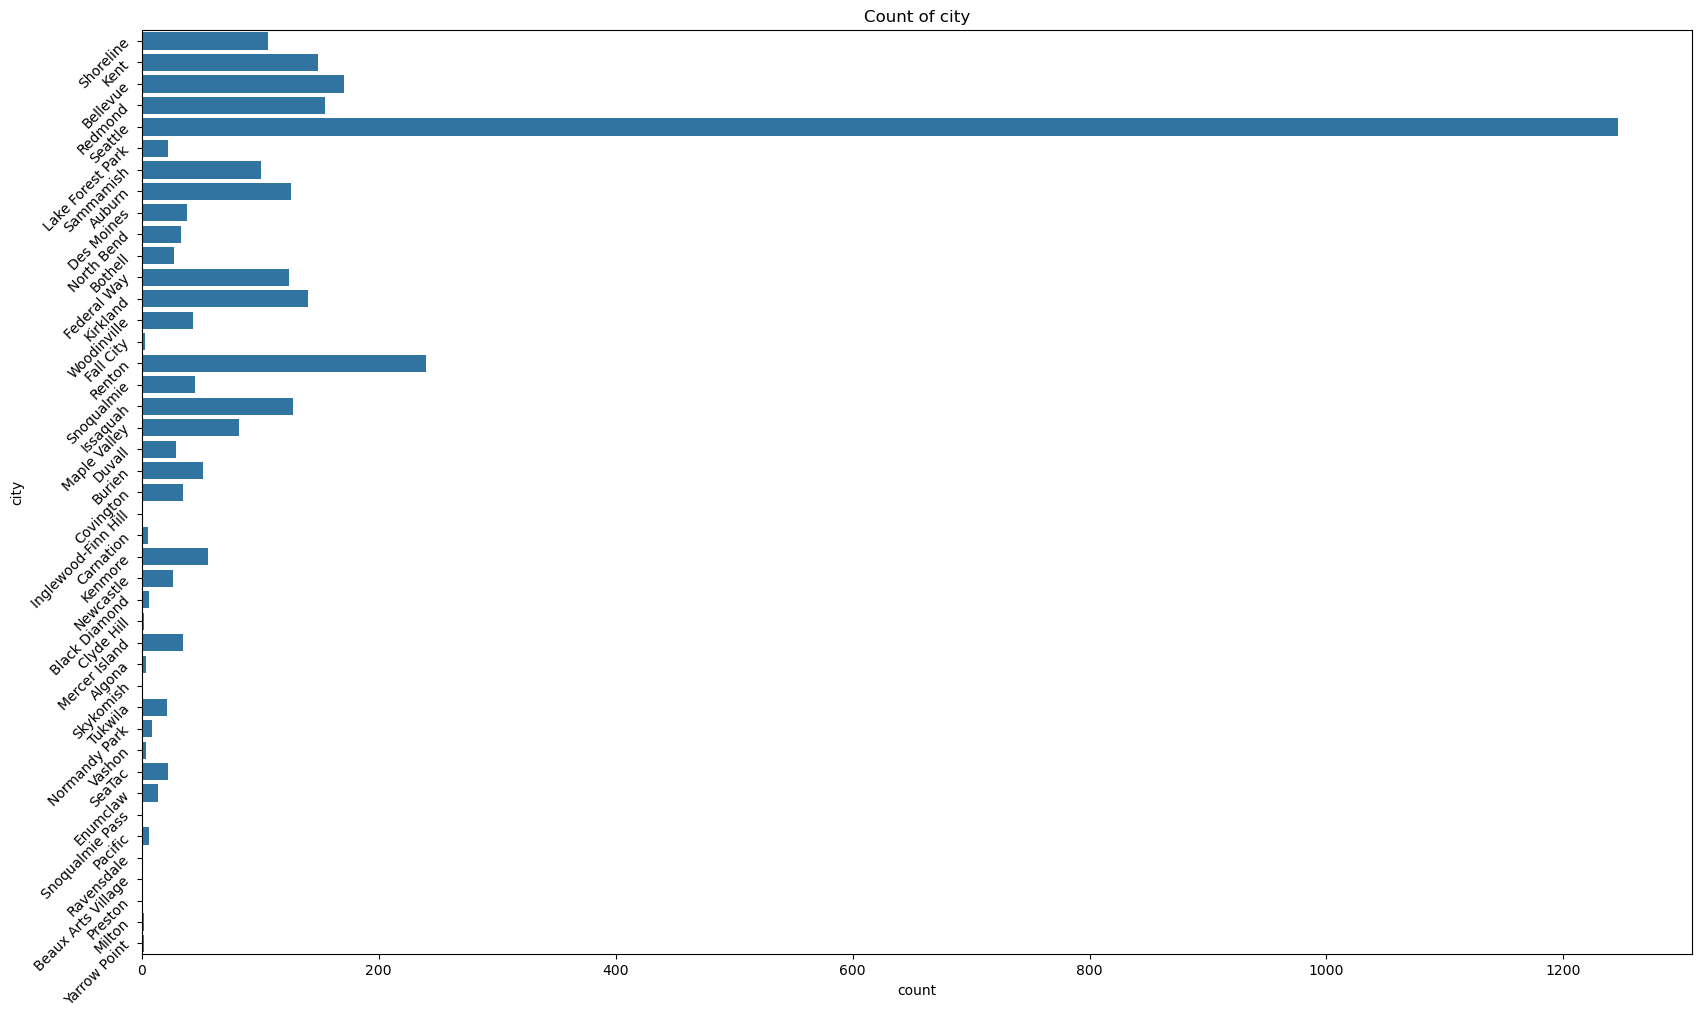

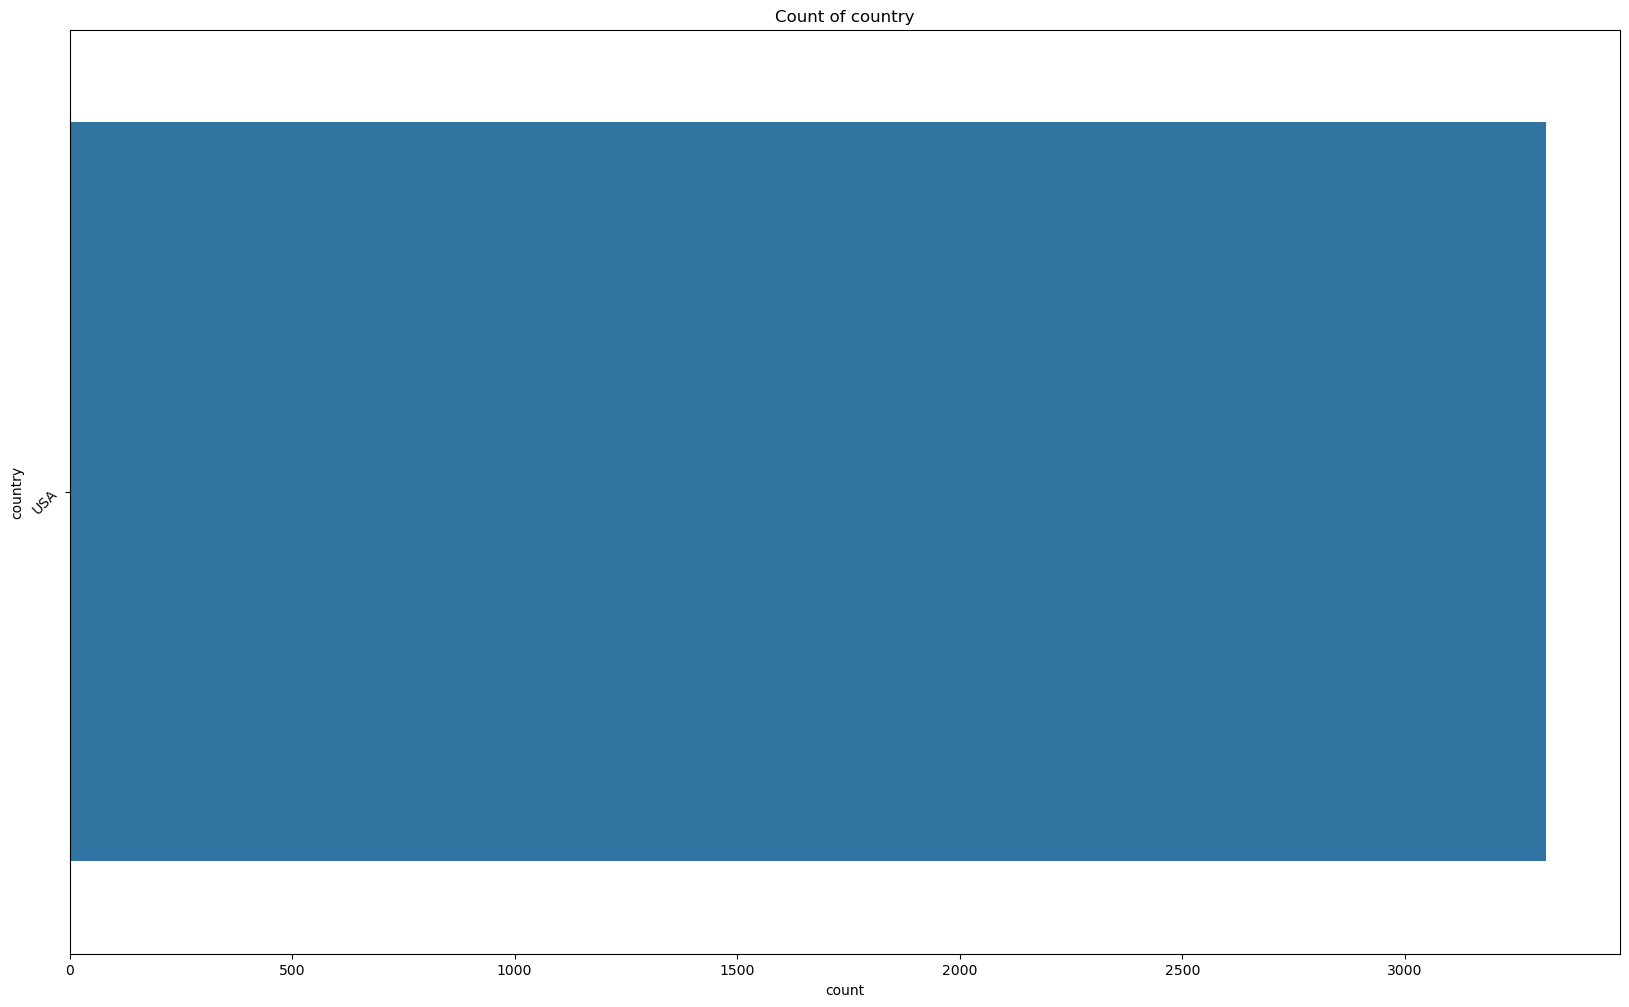

In [8]:
# Analyse categorical columns
cat_cols = df_without_outlier.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col not in ['date','street','statezip']:
        plt.figure(figsize=(20,12))
        sns.countplot(df_without_outlier[col])
        plt.title(f"Count of {col}")
        plt.yticks(rotation=45)
        plt.show()


In [9]:
# Now let's work on dividing features and target.
# then encoding and scaling
# finally modeling
top_cities = df_without_outlier['city'].value_counts().nlargest(10).index
df_without_outlier['city'] = df_without_outlier['city'].apply(lambda x: x if x in top_cities else 'Other')
df_without_outlier.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
5,2014-05-02 00:00:00,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA


# Modeling

In [10]:
# separating features and target
# here since simple we will include one feature
X = df_without_outlier[['sqft_living','bedrooms','bathrooms','sqft_lot','floors','sqft_above','yr_built','yr_renovated','city']]
y = df_without_outlier['price']
print(X.shape, y.shape)

(3316, 9) (3316,)


In [11]:
# dividing into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2652, 9) (664, 9) (2652,) (664,)


In [12]:
# Preprocessing and modeling steps
numerical_features = X_train.select_dtypes(include=['int64','float64']).columns.to_list()
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [13]:
# Fit and Evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [14]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
print(f"Mean Sqaured Error: {mse: .2f}")
print(f"Root Mean Squared Error: {rmse: .2f}")
print(f"Mean Absolute Error: {mae: .2f}")
print(f"R2 Score: {r2: .3f}")

Mean Sqaured Error:  14265042939.71
Root Mean Squared Error:  119436.36
Mean Absolute Error:  87580.41
R2 Score:  0.626


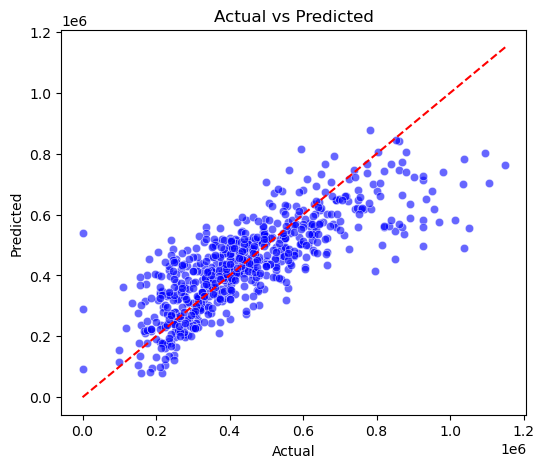

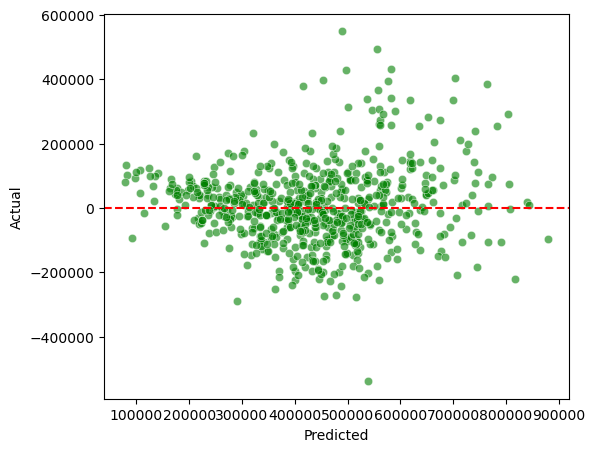

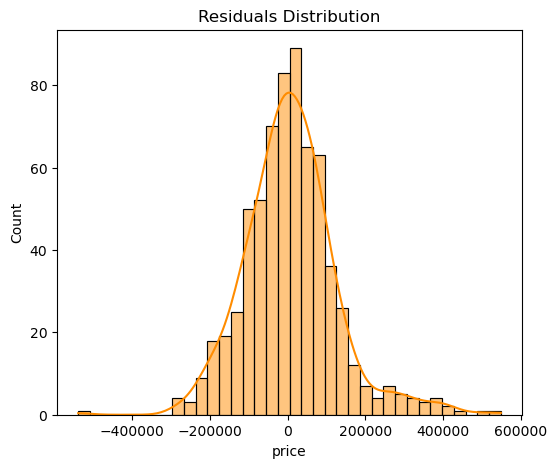

In [17]:
# Visualization 
residual = y_test - y_pred

# actual vs predicted
plt.figure(figsize=(6,5))
sns.scatterplot(x = y_test, y = y_pred, color = 'blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--') 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# residual plot
plt.figure(figsize=(6,5))
sns.scatterplot(x = y_pred, y = residual, color = 'green', alpha = 0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# residual distribution
plt.figure(figsize=(6,5))
sns.histplot(residual, kde=True, color = 'darkorange')
plt.title("Residuals Distribution")
plt.show()